# IE 360 Assignment 2

## Data Preparation

In [1]:
# Import required libraries

require(data.table)
require(ggplot2)
require(stringr)
require(tseries)
require(forecast)
require(GGally)
require(car)

# Read data
data_path='IE360_Spring22_HW2_data.csv'
consumption=fread(data_path)

Loading required package: data.table
Warning message:
"package 'data.table' was built under R version 3.6.3"Loading required package: ggplot2
Warning message:
"package 'ggplot2' was built under R version 4.0.5"Loading required package: stringr
Warning message:
"package 'stringr' was built under R version 3.6.3"Loading required package: tseries
Warning message:
"package 'tseries' was built under R version 3.6.3"Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Loading required package: forecast
Warning message:
"package 'forecast' was built under R version 3.6.3"Loading required package: GGally
Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2
Loading required package: car
Loading required package: carData


In [2]:
# Convert column names to convenient ones.
colnames_original = colnames(consumption) # Save the original column names.
colnames(consumption) = c('quarter', 'UGS', 'RNUV', 'NLPG', 'PU', 'PG', 'NUGV',
                          'NDGV', 'gnp_agriculture', 'gnp_commerce', 'gnp_total')

In [3]:
# Fix the formats of some inputs.
consumption$UGS = as.integer(gsub(" ","",consumption$UGS))
consumption$NLPG = as.integer(gsub(" ","",consumption$NLPG))
consumption$NUGV = as.integer(gsub(" ","",consumption$NUGV))
consumption$gnp_agriculture = as.integer(gsub(" ","",consumption$gnp_agriculture))
consumption$gnp_commerce = as.integer(gsub(" ","",consumption$gnp_commerce))
consumption$gnp_total = as.integer(gsub(" ","",consumption$gnp_total))

In [4]:
str(consumption)  # We are ready to go.

Classes 'data.table' and 'data.frame':	32 obs. of  11 variables:
 $ quarter        : chr  "2000_Q1" "2000_Q2" "2000_Q3" "2000_Q4" ...
 $ UGS            : int  1128971 1199569 1370167 1127548 1033918 1019754 1209916 1002789 893722 1027252 ...
 $ RNUV           : num  0.0146 0.0205 0.0207 0.0163 0.0071 0.0051 0.0041 0.0048 0.0012 0.0032 ...
 $ NLPG           : int  940000 941000 943500 948000 950000 955000 967500 990000 1000000 1001000 ...
 $ PU             : num  469 459 440 402 412 ...
 $ PG             : num  356 345 327 301 306 ...
 $ NUGV           : int  4647500 4742876 4840931 4919685 4954754 4980204 5000446 5024693 5030810 5046960 ...
 $ NDGV           : num  282 284 287 288 288 ...
 $ gnp_agriculture: int  1040173 1760460 6974808 3267125 1004528 1449357 5890424 1940854 832953 1419764 ...
 $ gnp_commerce   : int  3483132 4525451 5915204 4929778 3418387 4359831 5925547 4559190 3374849 4363782 ...
 $ gnp_total      : int  18022686 21797130 30050207 24480153 15832648 20296918 280179

In [5]:
# Add trend to the data
consumption[,trend:=1:.N]

# Split quarter column to get year and season.
split_column = stringr::str_split_fixed(consumption$quarter,'_',2)
consumption$year=stringr::str_split_fixed(consumption$quarter,'_',2)[,1]
consumption$season=stringr::str_split_fixed(consumption$quarter,'_',2)[,2]

## Task 1

### In this task, we are required to plot the output variable (UGS) and comment on its shape and whether it is stationary or not.

In [6]:
#Remove null values of UGS
consumption_ = copy(consumption[complete.cases(consumption)])

# Log transform UGS, to check if is betters in terms of variance and linearity
consumption_$UGS_log = log(consumption_$UGS)

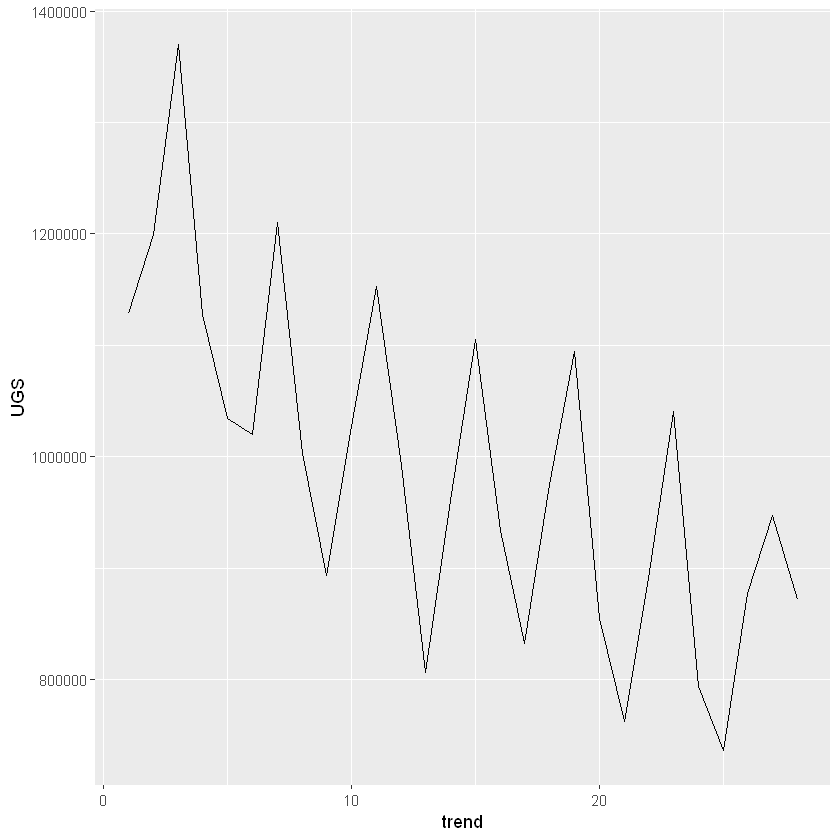

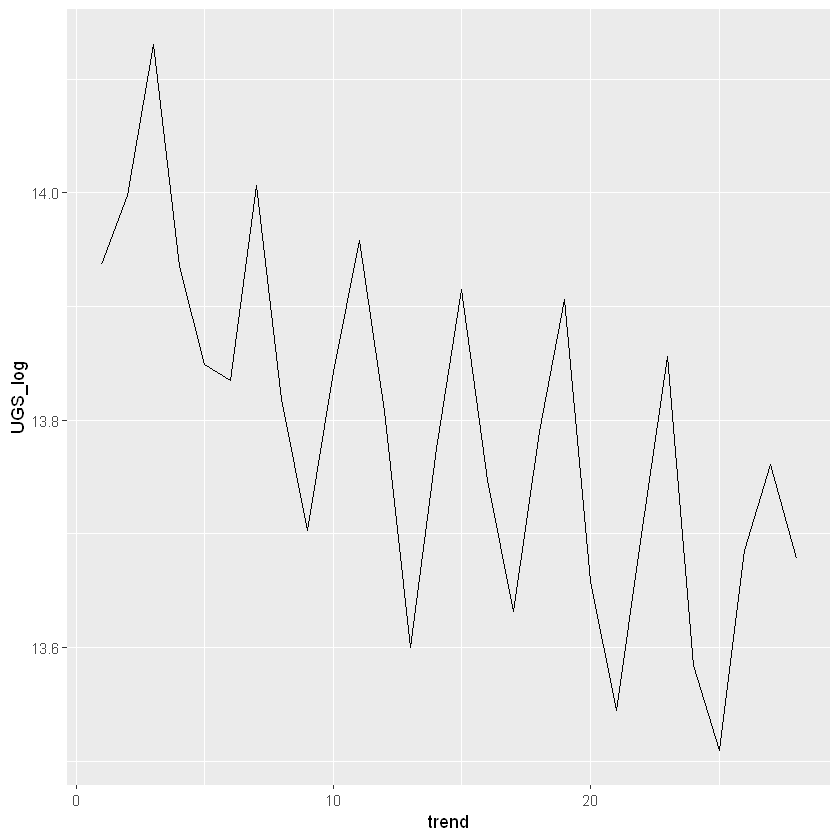

In [7]:
# Plotting UGS time series
ggplot(consumption_,aes(x=trend,y=UGS)) + geom_line()
ggplot(consumption_,aes(x=trend,y=UGS_log)) + geom_line()

### Log transformation didn't have a significant change in the data, therefore I will not use it.

### Looking at the plot, we can say that there is a seasonality in the data.

### It seems like constant variance condition is satisfied. However, mean is not constant, therefore this series is not stationary. We can use the stationarity test to verify this.

In [8]:
consumption_$UGS_log = NULL # Delete the log transformation, since it will not be used anyways.

In [9]:
kpss.test(consumption_$UGS)

Warning message in kpss.test(consumption_$UGS):
"p-value smaller than printed p-value"


	KPSS Test for Level Stationarity

data:  consumption_$UGS
KPSS Level = 0.81486, Truncation lag parameter = 2, p-value = 0.01


### p < 0.05, therefore null hypothesis is rejected. Series is not stationary.

## Task 2

### In this task, we will check which lags of the output data might be useful in our model.

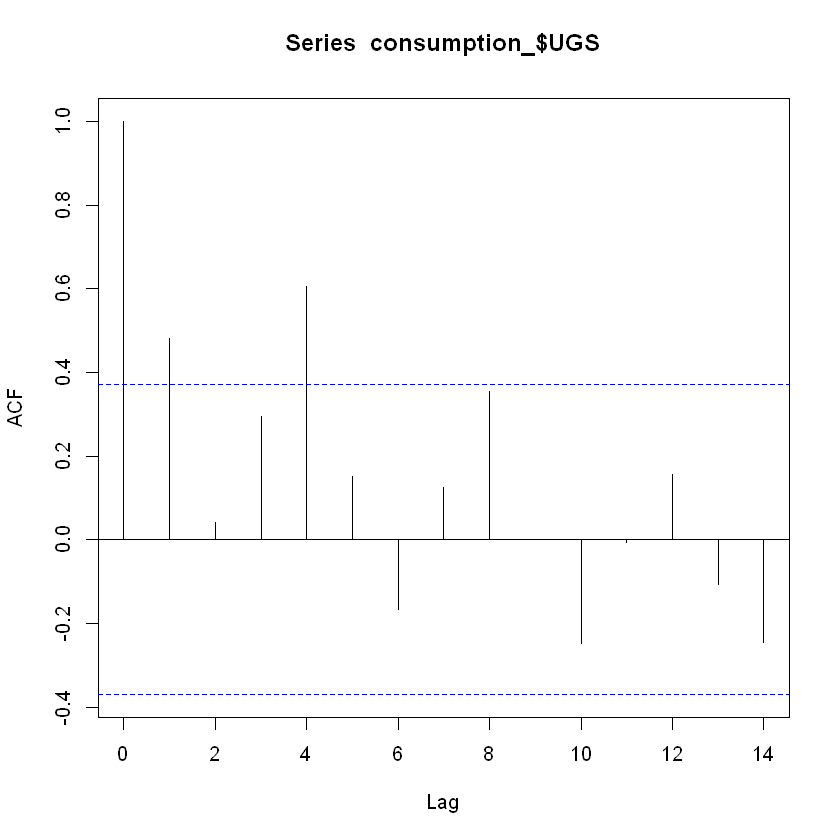

In [10]:
# Plotting the ACF graph
acf(consumption_$UGS)

### Lag-1 and Lag-4 are significantly correlated with Lag-0. Lag-1 represents Trend, and Lag-4 represents Seasonality (quarters of the year).

## Task 3 and 4

### In this task, we will first model the data with trend and seasonality. Then, we will check CCF between input variables and residuals obtained from linear model to see if lagged input variables might be useful, and build models with them.

In [11]:
lm_base = lm(UGS~trend+season, data=consumption_)
summary(lm_base)


Call:
lm(formula = UGS ~ trend + season, data = consumption_)

Residuals:
   Min     1Q Median     3Q    Max 
-81167 -31283  -3458  28640  94502 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1060372      23653  44.830  < 2e-16 ***
trend         -13497       1147 -11.764 3.28e-11 ***
seasonQ2      121532      25987   4.677 0.000104 ***
seasonQ3      273619      26063  10.498 3.03e-10 ***
seasonQ4       95049      26189   3.629 0.001405 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 48570 on 23 degrees of freedom
Multiple R-squared:  0.9119,	Adjusted R-squared:  0.8966 
F-statistic: 59.53 on 4 and 23 DF,  p-value: 8.446e-12


### Even trend and seasonality themselves perform quite well. It is expected because series has a constant variance and its average change in time is linear.

Warning message in modeldf.default(object):
"Could not find appropriate degrees of freedom for this model."

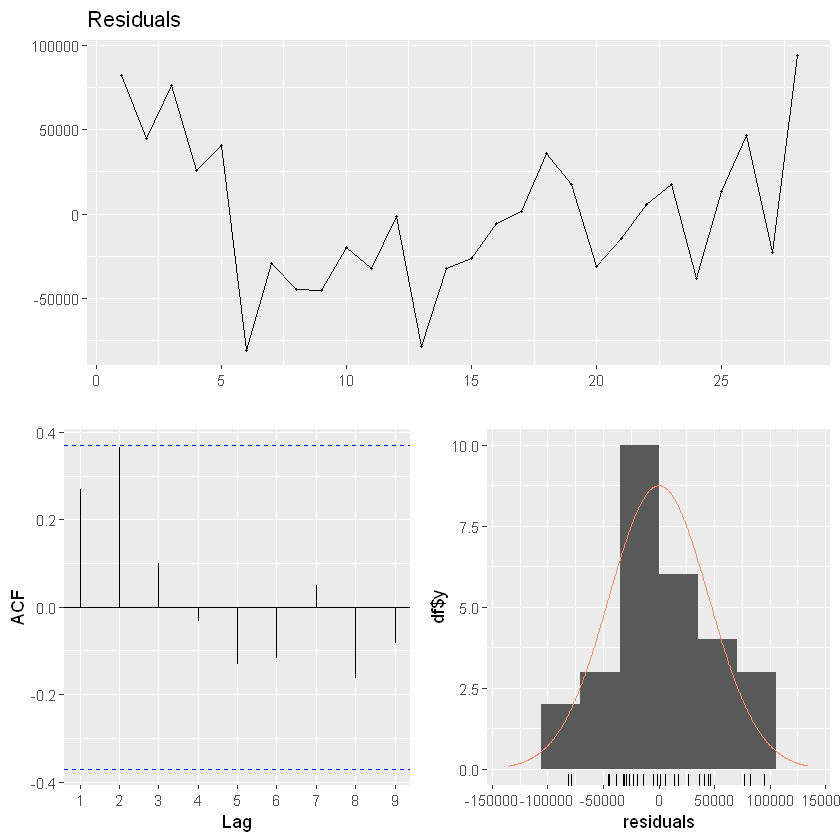

In [12]:
# Check residuals to see if they are random with constant variance

checkresiduals(lm_base$residuals)

### It seems like they are not totally random, and there is also bias (they are not deviating around zero). I will check correlation of data and residuals.

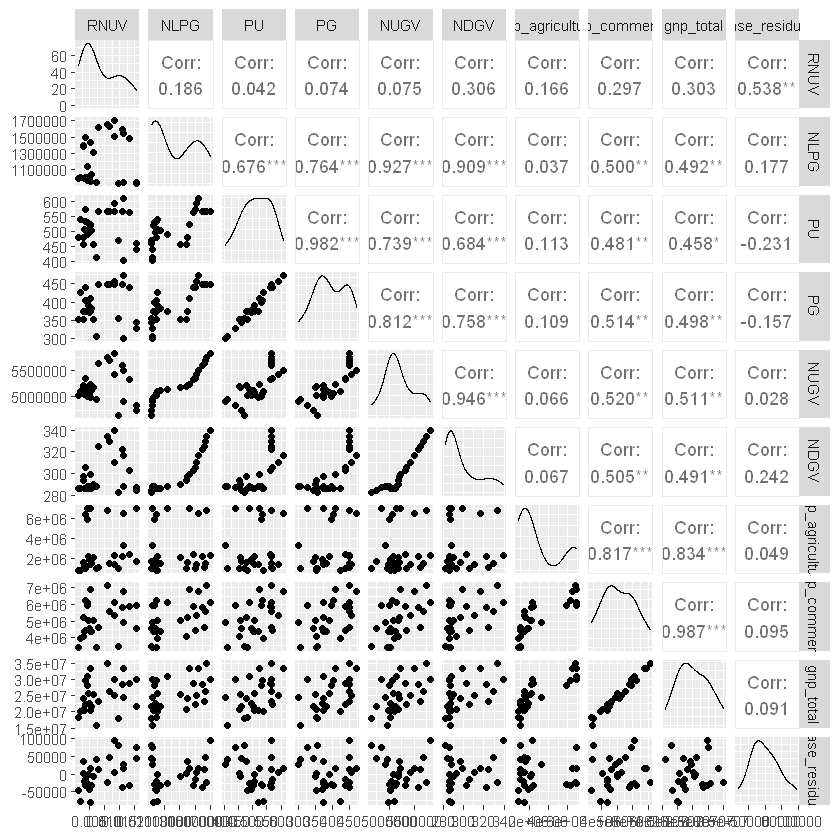

In [13]:
consumption_$base_residual = lm_base$residuals
ggpairs(consumption_[,-c('UGS', 'quarter', 'trend', 'year', 'season')])

### Only RNUV have a significant correlation with residuals. We might check PU and NDGV as well, but it is highly unlikely that they will be beneficial to the model.

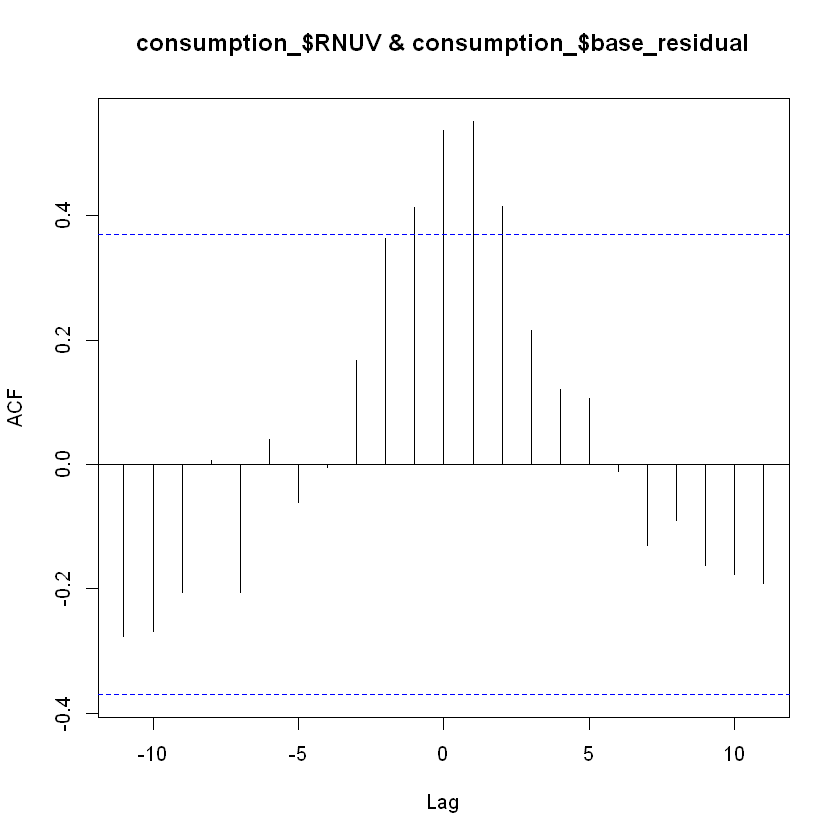

In [14]:
ccf(x=consumption_$RNUV, consumption_$base_residual)

### Lag-1 of RNUV has a significant correlation with residuals. It could benefit the model.

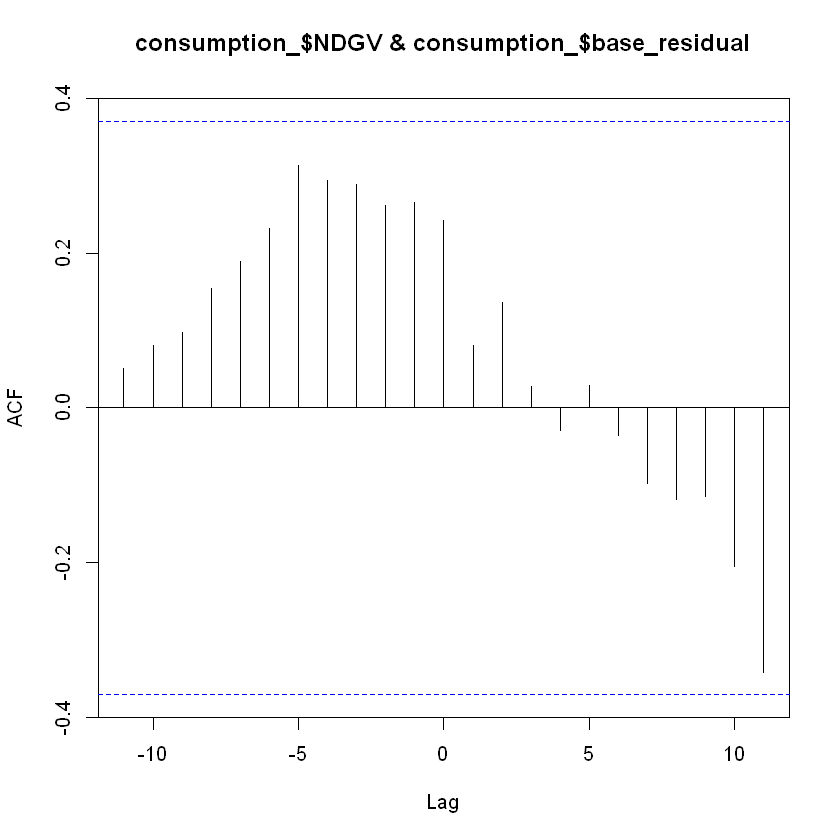

In [15]:
ccf(x=consumption_$NDGV, consumption_$base_residual)

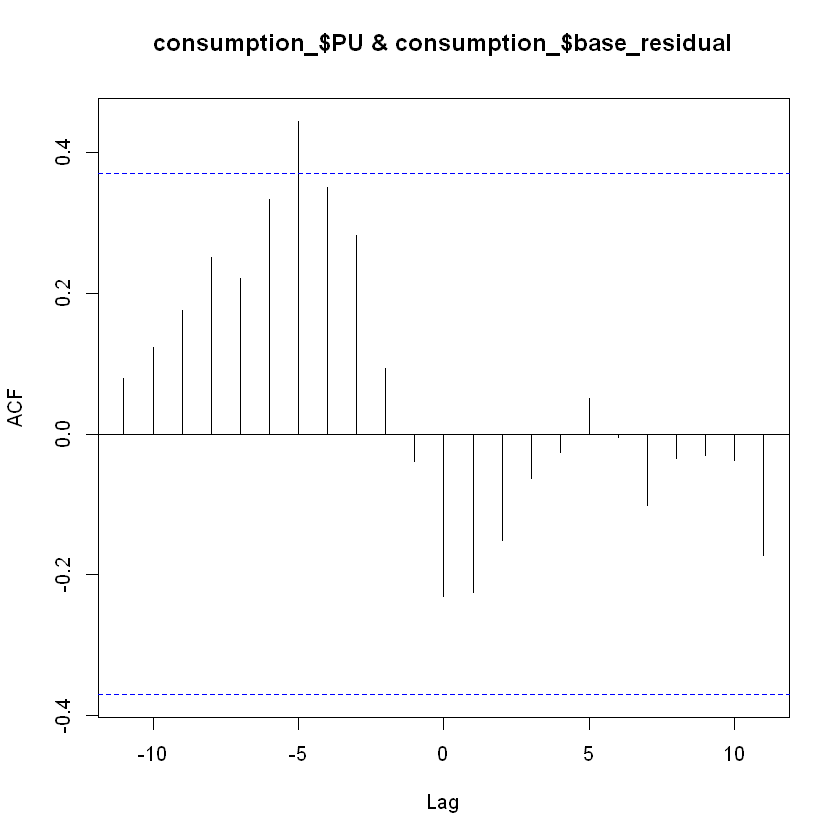

In [16]:
ccf(x=consumption_$PU, consumption_$base_residual)

### None of the lags of NDGV has significant correlation with residuals. Lag-5 of PU has a significant correlation with output. It could be tried to see if it improves the model.

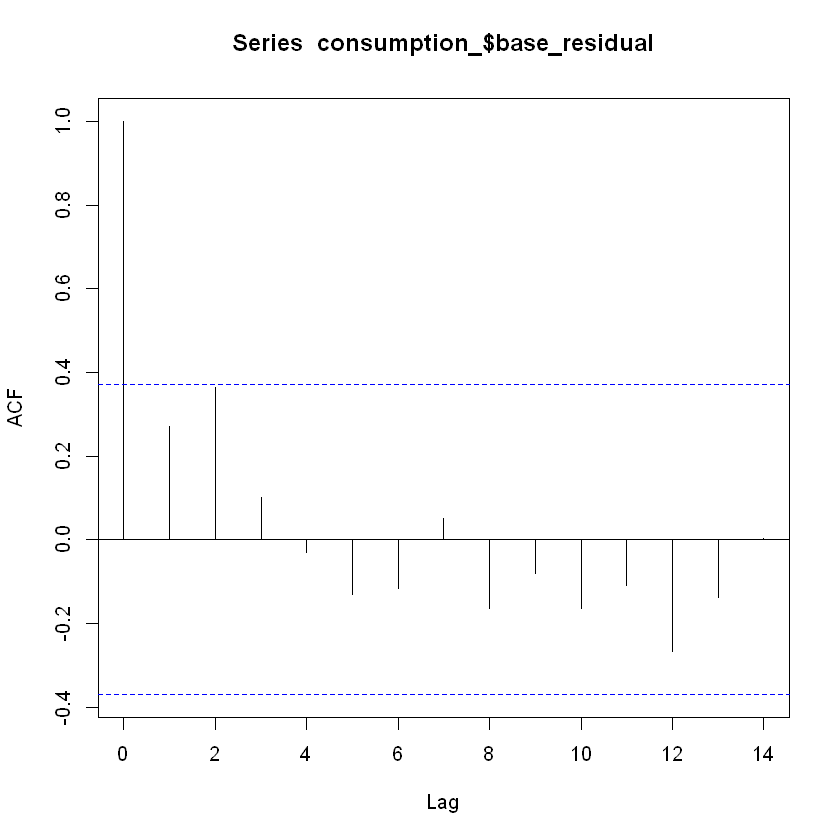

In [17]:
# Check autocorrelation of residuals

acf(consumption_$base_residual)

### Residuals doesn't have significant autocorrelation. Now, we will add the suggested variables and check if our model improves.

In [18]:
consumption_$RNUV_lag1 = c(NA,head(consumption_$RNUV, -1))

In [19]:
# We need to remove first row, because it has a missing input data that linear regression can't use.

consumption_2 = copy(consumption_[complete.cases(consumption_)])

In [20]:
# Building the model with lag-1 of RUNV

lm_lagged = lm(UGS~trend+season+RNUV_lag1, data=consumption_2)
summary(lm_lagged)


Call:
lm(formula = UGS ~ trend + season + RNUV_lag1, data = consumption_2)

Residuals:
   Min     1Q Median     3Q    Max 
-79545 -18338  -3014  25398  77667 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  992043.3    27044.7  36.682  < 2e-16 ***
trend        -12595.9      989.6 -12.729 2.44e-11 ***
seasonQ2     156124.0    23304.1   6.699 1.25e-06 ***
seasonQ3     295164.5    22310.0  13.230 1.18e-11 ***
seasonQ4     114350.0    22269.2   5.135 4.36e-05 ***
RNUV_lag1   3761501.8  1346502.2   2.794   0.0109 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 39780 on 21 degrees of freedom
Multiple R-squared:  0.9442,	Adjusted R-squared:  0.9309 
F-statistic: 71.01 on 5 and 21 DF,  p-value: 1.95e-12


Warning message in modeldf.default(object):
"Could not find appropriate degrees of freedom for this model."

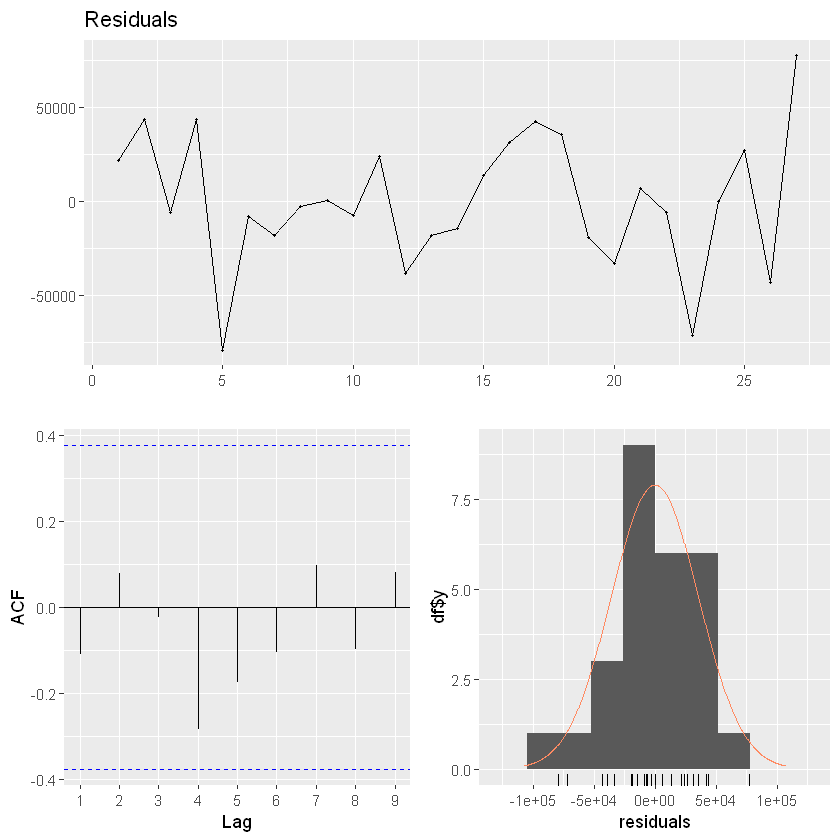

In [21]:
checkresiduals(lm_lagged$residuals)

### New variable is important (p-value < 0.05). ACF of residuals are a lot better. Range of the errors changed from (-81000,94000) to (-79000,77000) approximately. Residual standard error decreased from 48000 to 40000. They seem to deviate around zero and don't have bias.

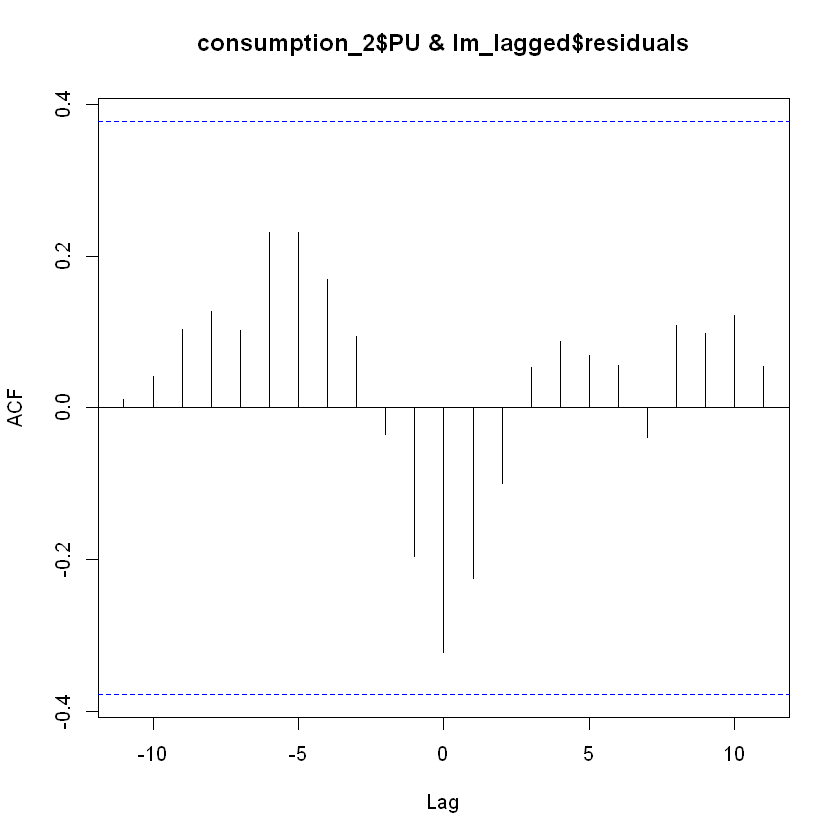

In [22]:
# Let's check if lag-5 of PU is still significantly correlated with residuals.

ccf(consumption_2$PU, lm_lagged$residuals)

### Lag-5 of PU is not significantly correlated with the last model. Therefore, it will not be added as an input.

## Task 5

### In this task, we will justify our time series regression model (how we arrived to the final model).

In [23]:
summary(lm_lagged)


Call:
lm(formula = UGS ~ trend + season + RNUV_lag1, data = consumption_2)

Residuals:
   Min     1Q Median     3Q    Max 
-79545 -18338  -3014  25398  77667 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  992043.3    27044.7  36.682  < 2e-16 ***
trend        -12595.9      989.6 -12.729 2.44e-11 ***
seasonQ2     156124.0    23304.1   6.699 1.25e-06 ***
seasonQ3     295164.5    22310.0  13.230 1.18e-11 ***
seasonQ4     114350.0    22269.2   5.135 4.36e-05 ***
RNUV_lag1   3761501.8  1346502.2   2.794   0.0109 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 39780 on 21 degrees of freedom
Multiple R-squared:  0.9442,	Adjusted R-squared:  0.9309 
F-statistic: 71.01 on 5 and 21 DF,  p-value: 1.95e-12


### First, we added seasonality and trend because plot of the output variable suggested so. They came up as significant.
### Then, we removed effects of seasonality and trend to have residuals. We checked (for inputs that have high correlation with output) if any of the lags of variables have correlation with residuals. Two of them seemed to have correlation (RNUV_lag1 and PU_lag5). 
### We added  lag-1 of RUNV. It came up as significant and residuals improved. Then, we checked CCF of new residuals with other input variables. Their lags didn't have significant correlation with new residuals. New residuals don't have significant autocorrelation as well. Therefore, we conclude our analysis with the final regression model we obtained.

### It should be noted that we could add more variables to get smaller errors and better R squared values. However, it would probably result in an overfitted model.

### Validation set approach could be used to further check validity of the model but it is out of the scope for now.

## Task 6

### In this task, we will make predictions for year 2007.

In [24]:
# Create lag variable in the original data.
consumption$RNUV_lag1 = c(NA,head(consumption$RNUV, -1))

In [25]:
# Select last 4 rows (2007).
to_predict = consumption[,tail(.SD,4)]

In [26]:
to_predict

quarter,UGS,RNUV,NLPG,PU,PG,NUGV,NDGV,gnp_agriculture,gnp_commerce,gnp_total,trend,year,season,RNUV_lag1
2007_Q1,NA,0.0074,1715000,565.19,449.19,5869018,342.1729,1132973,4857305,24413807,29,2007,Q1,0.0133
2007_Q2,NA,0.0106,1725300,565.19,449.19,5931348,346.9407,1570703,5852404,27597857,30,2007,Q2,0.0074
2007_Q3,NA,0.0101,1751050,565.19,449.19,5991280,351.4449,7140722,7480414,36741745,31,2007,Q3,0.0106
2007_Q4,NA,0.0124,1797400,565.19,449.19,6065597,357.2902,2418541,6397745,31361112,32,2007,Q4,0.0101


In [27]:
# Make predictions.
predictions = predict(lm_lagged, to_predict)
predictions

1        2        3        4 
676791.0 798126.3 936607.7 741316.6

In [28]:
# Combine predictions with actual
consumption$output_with_forecast = c(consumption[,head(.SD,-4)]$UGS, predictions)

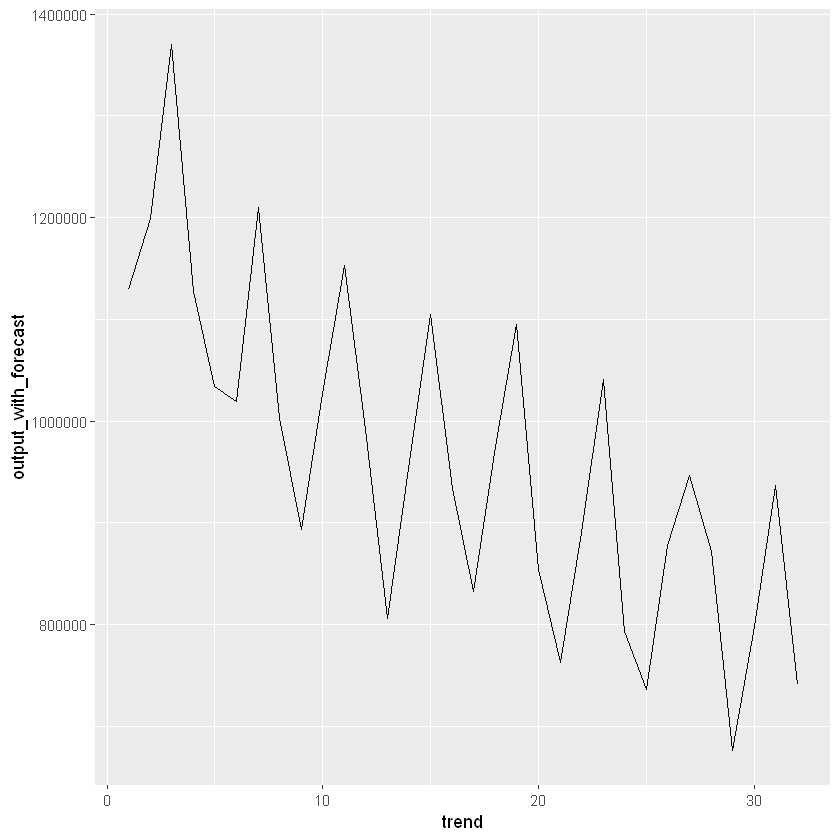

In [29]:
# Plot actuals with forecast
ggplot(consumption,aes(x=trend,y=output_with_forecast)) + geom_line()

### It is seen that our model didn't get affected by the sudden, unexpected decrease in 2006, and followed the same pattern with the pre-2006 data.